# Image Classification

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


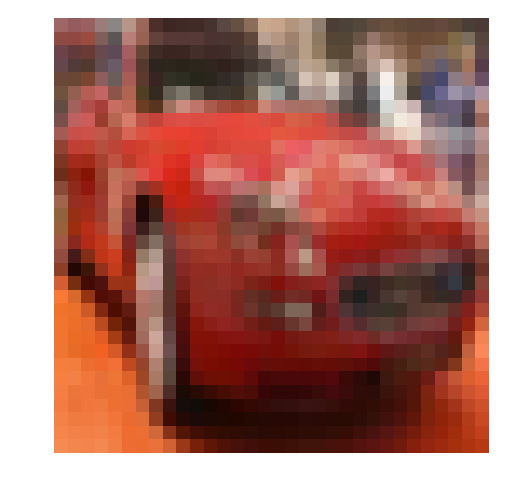

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
The `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [5]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TO-DO: need to init as a numpy array 
    norm_arr = []
    for arr in x:
        # better ways to do this other than dividing the max?
        arr = arr / np.amax(arr)
        norm_arr.append(arr)
    # can't we just use tf.image.per_image_standardization?
    return np.array(norm_arr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


In [6]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    return np.eye(10)[x]


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=(None, image_shape[0],  image_shape[1], image_shape[2]), name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape=(None, n_classes), name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    input_shape = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal((conv_ksize[0], conv_ksize[1], input_shape[3], conv_num_outputs)))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    conv = tf.nn.conv2d(x_tensor, weights, [1, conv_strides[0], conv_strides[1], 1], 'SAME')
    conv = tf.nn.bias_add(conv, bias)
    conv = tf.nn.relu(conv)
    
    pool = tf.nn.max_pool(conv, [1, pool_ksize[0], pool_ksize[1], 1], [1, pool_strides[0], pool_strides[1], 1], 'SAME')
    
    return pool


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer

In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    input_shape = x_tensor.get_shape().as_list()
    flatten_image = input_shape[1]*input_shape[2]*input_shape[3]
    
    # use -1 to infer the shape
    flatten_layer = tf.reshape(x_tensor, [-1, flatten_image])

    return flatten_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer

In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    input_shape = x_tensor.get_shape().as_list()
    weight = tf.Variable(tf.random_normal([input_shape[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    
    fully_conn = tf.add(tf.matmul(x_tensor, weight), bias)
    fully_conn = tf.nn.relu(fully_conn)

    return fully_conn


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    input_shape = x_tensor.get_shape().as_list()
    weight = tf.Variable(tf.random_normal([input_shape[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    
    output_layer = tf.add(tf.matmul(x_tensor, weight), bias)
    return output_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model

In [14]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    # Tensor("Placeholder_32:0", shape=(?, 32, 32, 5), dtype=float32) 10 (2, 2) (4, 4) (2, 2) (2, 2)
    x = conv2d_maxpool(x, 10, (2, 2), (4, 4), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 10, (2, 2), (4, 4), (2, 2), (2, 2))
    x = conv2d_maxpool(x, 10, (2, 2), (4, 4), (2, 2), (2, 2))
    

    # Function Definition from Above:
    #   flatten(x_tensor)
    x = flatten(x)
    
    
    #keep_prob = keep_prob.get_shape().as_list()
    # print(keep_prob.get_shape())
    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    x = fully_conn(x, 40)
    #x = tf.nn.dropout(x, 0.5)
    x = fully_conn(x, 40)
    #x = tf.nn.dropout(x, 0.5)
    
    
    # Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    x = output(x, 10)
    
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization

In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.0})
    valid_acc = session.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.0})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for
* Set `keep_probability` to the probability of keeping a node using dropout

In [24]:
# TODO: Tune Parameters
epochs = 1000
batch_size = 1024
keep_probability = 0.7

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:  1139.7522 Validation Accuracy: 0.105400
Epoch  2, CIFAR-10 Batch 1:  Loss:   787.2209 Validation Accuracy: 0.100400
Epoch  3, CIFAR-10 Batch 1:  Loss:   499.5923 Validation Accuracy: 0.094000
Epoch  4, CIFAR-10 Batch 1:  Loss:   349.4072 Validation Accuracy: 0.103800
Epoch  5, CIFAR-10 Batch 1:  Loss:   279.2068 Validation Accuracy: 0.092200
Epoch  6, CIFAR-10 Batch 1:  Loss:   214.7446 Validation Accuracy: 0.119800
Epoch  7, CIFAR-10 Batch 1:  Loss:   177.1291 Validation Accuracy: 0.106600
Epoch  8, CIFAR-10 Batch 1:  Loss:   151.3334 Validation Accuracy: 0.112000
Epoch  9, CIFAR-10 Batch 1:  Loss:   124.1798 Validation Accuracy: 0.120400
Epoch 10, CIFAR-10 Batch 1:  Loss:   109.6115 Validation Accuracy: 0.121800
Epoch 11, CIFAR-10 Batch 1:  Loss:   100.8999 Validation Accuracy: 0.125600
Epoch 12, CIFAR-10 Batch 1:  Loss:    98.6264 Validation Accuracy: 0.123400
Epoch 13, CIFAR-10 Batch 1:  Loss:    94.7259

Epoch 214, CIFAR-10 Batch 1:  Loss:     3.2128 Validation Accuracy: 0.146800
Epoch 215, CIFAR-10 Batch 1:  Loss:     2.8800 Validation Accuracy: 0.156200
Epoch 216, CIFAR-10 Batch 1:  Loss:     2.8831 Validation Accuracy: 0.162000
Epoch 217, CIFAR-10 Batch 1:  Loss:     2.7798 Validation Accuracy: 0.176600
Epoch 218, CIFAR-10 Batch 1:  Loss:     2.8272 Validation Accuracy: 0.175600
Epoch 219, CIFAR-10 Batch 1:  Loss:     2.7776 Validation Accuracy: 0.172400
Epoch 220, CIFAR-10 Batch 1:  Loss:     2.8031 Validation Accuracy: 0.142000
Epoch 221, CIFAR-10 Batch 1:  Loss:     2.7883 Validation Accuracy: 0.154000
Epoch 222, CIFAR-10 Batch 1:  Loss:     2.7793 Validation Accuracy: 0.140000
Epoch 223, CIFAR-10 Batch 1:  Loss:     2.6887 Validation Accuracy: 0.155000
Epoch 224, CIFAR-10 Batch 1:  Loss:     2.7083 Validation Accuracy: 0.155200
Epoch 225, CIFAR-10 Batch 1:  Loss:     2.7117 Validation Accuracy: 0.157800
Epoch 226, CIFAR-10 Batch 1:  Loss:     2.7166 Validation Accuracy: 0.164600

Epoch 426, CIFAR-10 Batch 1:  Loss:     2.5503 Validation Accuracy: 0.161800
Epoch 427, CIFAR-10 Batch 1:  Loss:     2.5345 Validation Accuracy: 0.158600
Epoch 428, CIFAR-10 Batch 1:  Loss:     2.5014 Validation Accuracy: 0.156200
Epoch 429, CIFAR-10 Batch 1:  Loss:     2.5060 Validation Accuracy: 0.155400
Epoch 430, CIFAR-10 Batch 1:  Loss:     2.5644 Validation Accuracy: 0.153600
Epoch 431, CIFAR-10 Batch 1:  Loss:     2.6150 Validation Accuracy: 0.155200
Epoch 432, CIFAR-10 Batch 1:  Loss:     2.6278 Validation Accuracy: 0.150200
Epoch 433, CIFAR-10 Batch 1:  Loss:     2.7004 Validation Accuracy: 0.145400
Epoch 434, CIFAR-10 Batch 1:  Loss:     2.5870 Validation Accuracy: 0.148000
Epoch 435, CIFAR-10 Batch 1:  Loss:     2.5230 Validation Accuracy: 0.143800
Epoch 436, CIFAR-10 Batch 1:  Loss:     2.5201 Validation Accuracy: 0.160800
Epoch 437, CIFAR-10 Batch 1:  Loss:     2.4699 Validation Accuracy: 0.163000
Epoch 438, CIFAR-10 Batch 1:  Loss:     2.4768 Validation Accuracy: 0.151600

Epoch 638, CIFAR-10 Batch 1:  Loss:     5.2339 Validation Accuracy: 0.106200
Epoch 639, CIFAR-10 Batch 1:  Loss:     3.5326 Validation Accuracy: 0.118200
Epoch 640, CIFAR-10 Batch 1:  Loss:     3.0855 Validation Accuracy: 0.137600
Epoch 641, CIFAR-10 Batch 1:  Loss:     2.7538 Validation Accuracy: 0.127000
Epoch 642, CIFAR-10 Batch 1:  Loss:     2.5433 Validation Accuracy: 0.168600
Epoch 643, CIFAR-10 Batch 1:  Loss:     2.4330 Validation Accuracy: 0.169800
Epoch 644, CIFAR-10 Batch 1:  Loss:     2.4207 Validation Accuracy: 0.155600
Epoch 645, CIFAR-10 Batch 1:  Loss:     2.3809 Validation Accuracy: 0.159800
Epoch 646, CIFAR-10 Batch 1:  Loss:     2.3853 Validation Accuracy: 0.160800
Epoch 647, CIFAR-10 Batch 1:  Loss:     2.3887 Validation Accuracy: 0.164400
Epoch 648, CIFAR-10 Batch 1:  Loss:     2.3808 Validation Accuracy: 0.166600
Epoch 649, CIFAR-10 Batch 1:  Loss:     2.3803 Validation Accuracy: 0.165600
Epoch 650, CIFAR-10 Batch 1:  Loss:     2.3650 Validation Accuracy: 0.166400

Epoch 850, CIFAR-10 Batch 1:  Loss:     2.3183 Validation Accuracy: 0.150000
Epoch 851, CIFAR-10 Batch 1:  Loss:     2.3169 Validation Accuracy: 0.144200
Epoch 852, CIFAR-10 Batch 1:  Loss:     3.0715 Validation Accuracy: 0.150200
Epoch 853, CIFAR-10 Batch 1:  Loss:     3.0574 Validation Accuracy: 0.125800
Epoch 854, CIFAR-10 Batch 1:  Loss:     4.0780 Validation Accuracy: 0.106400
Epoch 855, CIFAR-10 Batch 1:  Loss:     3.4846 Validation Accuracy: 0.142200
Epoch 856, CIFAR-10 Batch 1:  Loss:     2.9549 Validation Accuracy: 0.152200
Epoch 857, CIFAR-10 Batch 1:  Loss:     2.5224 Validation Accuracy: 0.147200
Epoch 858, CIFAR-10 Batch 1:  Loss:     2.3271 Validation Accuracy: 0.150200
Epoch 859, CIFAR-10 Batch 1:  Loss:     2.3217 Validation Accuracy: 0.147200
Epoch 860, CIFAR-10 Batch 1:  Loss:     2.3070 Validation Accuracy: 0.163200
Epoch 861, CIFAR-10 Batch 1:  Loss:     2.2855 Validation Accuracy: 0.164000
Epoch 862, CIFAR-10 Batch 1:  Loss:     2.2644 Validation Accuracy: 0.165600

### Fully Train the Model
Try it with all five batches.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

# Checkpoint
The model has been saved to disk.
## Test Model

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()